# Working with Seismic Data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import obspy

## Filtering Seismograms

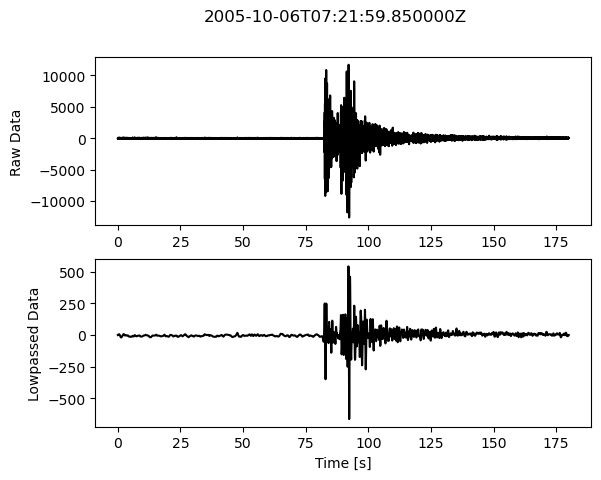

In [3]:
# Read the seismogram
st = obspy.read("https://examples.obspy.org/RJOB_061005_072159.ehz.new")

# There is only one trace in the Stream object, let's work on that trace...
tr = st[0]

# Filtering with a lowpass on a copy of the original Trace
tr_filt = tr.copy()
tr_filt.filter('lowpass', freq=1.0, corners=2, zerophase=True)

# Now let's plot the raw and filtered data...
t = np.arange(0, tr.stats.npts / tr.stats.sampling_rate, tr.stats.delta)
plt.subplot(211)
plt.plot(t, tr.data, 'k')
plt.ylabel('Raw Data')
plt.subplot(212)
plt.plot(t, tr_filt.data, 'k')
plt.ylabel('Lowpassed Data')
plt.xlabel('Time [s]')
plt.suptitle(tr.stats.starttime)
plt.show()

## Downsampling Seismograms

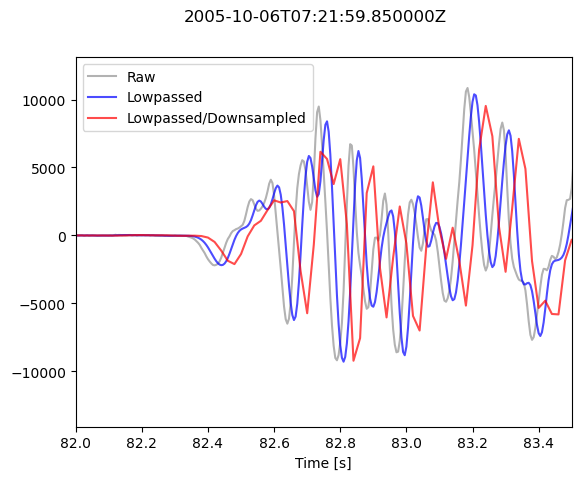

In [4]:
# Read the seismogram
st = obspy.read("https://examples.obspy.org/RJOB_061005_072159.ehz.new")

# There is only one trace in the Stream object, let's work on that trace...
tr = st[0]

# Decimate the 200 Hz data by a factor of 4 to 50 Hz. Note that this
# automatically includes a lowpass filtering with corner frequency 20 Hz.
# We work on a copy of the original data just to demonstrate the effects of
# downsampling.
tr_new = tr.copy()
tr_new.decimate(factor=4, strict_length=False)

# For comparison also only filter the original data (same filter options as in
# automatically applied filtering during downsampling, corner frequency
# 0.4 * new sampling rate)
tr_filt = tr.copy()
tr_filt.filter('lowpass', freq=0.4 * tr.stats.sampling_rate / 4.0)

# Now let's plot the raw and filtered data...
t = np.arange(0, tr.stats.npts / tr.stats.sampling_rate, tr.stats.delta)
t_new = np.arange(0, tr_new.stats.npts / tr_new.stats.sampling_rate,
                  tr_new.stats.delta)

plt.plot(t, tr.data, 'k', label='Raw', alpha=0.3)
plt.plot(t, tr_filt.data, 'b', label='Lowpassed', alpha=0.7)
plt.plot(t_new, tr_new.data, 'r', label='Lowpassed/Downsampled', alpha=0.7)
plt.xlabel('Time [s]')
plt.xlim(82, 83.5)
plt.suptitle(tr.stats.starttime)
plt.legend()
plt.show()

## Merging Seismograms

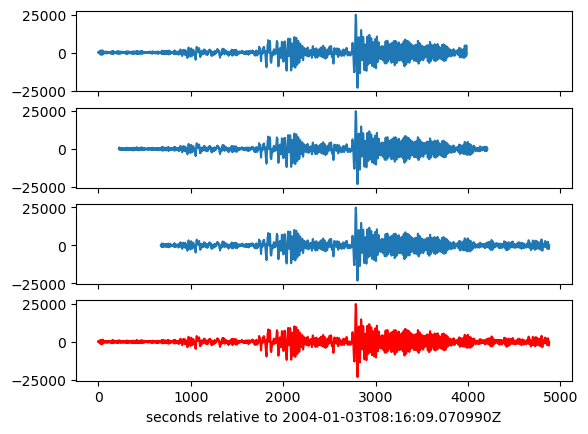

In [5]:
# Read in all files starting with dis.
st = obspy.read("https://examples.obspy.org/dis.G.SCZ.__.BHE")
st += obspy.read("https://examples.obspy.org/dis.G.SCZ.__.BHE.1")
st += obspy.read("https://examples.obspy.org/dis.G.SCZ.__.BHE.2")

# sort
st.sort(['starttime'])

# use common reference time and have x-Axis as relative time in seconds.
# Another option would be to plot absolute times by using
# Trace.times(type='matplotlib') and letting matplotlib know that x-Axis has
# absolute times, by using ax.xaxis_date() and fig.autofmt_xdate()
t0 = st[0].stats.starttime

# Go through the stream object and plot the data with a shared x axis
fig, axes = plt.subplots(nrows=len(st)+1, sharex=True)
ax = None

for (tr, ax) in zip(st, axes):
    ax.plot(tr.times(reftime=t0), tr.data)

# Merge the data together and plot in a similar way in the bottom Axes
st.merge(method=1)
axes[-1].plot(st[0].times(reftime=t0), st[0].data, 'r')
axes[-1].set_xlabel(f'seconds relative to {t0}')
plt.show()

## Beamforming - FK Analysis

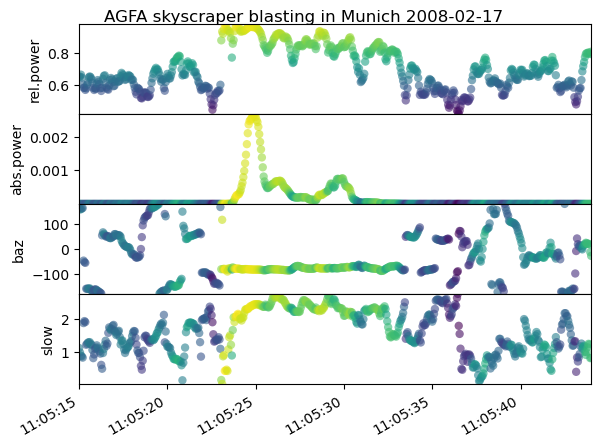

In [6]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import obspy
from obspy.core.util import AttribDict
from obspy.imaging.cm import obspy_sequential
from obspy.signal.invsim import corn_freq_2_paz
from obspy.signal.array_analysis import array_processing


# Load data
st = obspy.read("https://examples.obspy.org/agfa.mseed")

# Set PAZ and coordinates for all 5 channels
st[0].stats.paz = AttribDict({
    'poles': [(-0.03736 - 0.03617j), (-0.03736 + 0.03617j)],
    'zeros': [0j, 0j],
    'sensitivity': 205479446.68601453,
    'gain': 1.0})
st[0].stats.coordinates = AttribDict({
    'latitude': 48.108589,
    'elevation': 0.450000,
    'longitude': 11.582967})

st[1].stats.paz = AttribDict({
    'poles': [(-0.03736 - 0.03617j), (-0.03736 + 0.03617j)],
    'zeros': [0j, 0j],
    'sensitivity': 205479446.68601453,
    'gain': 1.0})
st[1].stats.coordinates = AttribDict({
    'latitude': 48.108192,
    'elevation': 0.450000,
    'longitude': 11.583120})

st[2].stats.paz = AttribDict({
    'poles': [(-0.03736 - 0.03617j), (-0.03736 + 0.03617j)],
    'zeros': [0j, 0j],
    'sensitivity': 250000000.0,
    'gain': 1.0})
st[2].stats.coordinates = AttribDict({
    'latitude': 48.108692,
    'elevation': 0.450000,
    'longitude': 11.583414})

st[3].stats.paz = AttribDict({
    'poles': [(-4.39823 + 4.48709j), (-4.39823 - 4.48709j)],
    'zeros': [0j, 0j],
    'sensitivity': 222222228.10910088,
    'gain': 1.0})
st[3].stats.coordinates = AttribDict({
    'latitude': 48.108456,
    'elevation': 0.450000,
    'longitude': 11.583049})

st[4].stats.paz = AttribDict({
    'poles': [(-4.39823 + 4.48709j), (-4.39823 - 4.48709j), (-2.105 + 0j)],
    'zeros': [0j, 0j, 0j],
    'sensitivity': 222222228.10910088,
    'gain': 1.0})
st[4].stats.coordinates = AttribDict({
    'latitude': 48.108730,
    'elevation': 0.450000,
    'longitude': 11.583157})


# Instrument correction to 1Hz corner frequency
paz1hz = corn_freq_2_paz(1.0, damp=0.707)
st.simulate(paz_remove='self', paz_simulate=paz1hz)

# Execute array_processing
stime = obspy.UTCDateTime("20080217110515")
etime = obspy.UTCDateTime("20080217110545")
kwargs = dict(
    # slowness grid: X min, X max, Y min, Y max, Slow Step
    sll_x=-3.0, slm_x=3.0, sll_y=-3.0, slm_y=3.0, sl_s=0.03,
    # sliding window properties
    win_len=1.0, win_frac=0.05,
    # frequency properties
    frqlow=1.0, frqhigh=8.0, prewhiten=0,
    # restrict output
    semb_thres=-1e9, vel_thres=-1e9, timestamp='mlabday',
    stime=stime, etime=etime
)
out = array_processing(st, **kwargs)

# Plot
labels = ['rel.power', 'abs.power', 'baz', 'slow']

xlocator = mdates.AutoDateLocator()
fig = plt.figure()
for i, lab in enumerate(labels):
    ax = fig.add_subplot(4, 1, i + 1)
    ax.scatter(out[:, 0], out[:, i + 1], c=out[:, 1], alpha=0.6,
               edgecolors='none', cmap=obspy_sequential)
    ax.set_ylabel(lab)
    ax.set_xlim(out[0, 0], out[-1, 0])
    ax.set_ylim(out[:, i + 1].min(), out[:, i + 1].max())
    ax.xaxis.set_major_locator(xlocator)
    ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(xlocator))

fig.suptitle('AGFA skyscraper blasting in Munich %s' % (
    stime.strftime('%Y-%m-%d'), ))
fig.autofmt_xdate()
fig.subplots_adjust(left=0.15, top=0.95, right=0.95, bottom=0.2, hspace=0)
plt.show()

Can be represented through a polar plot

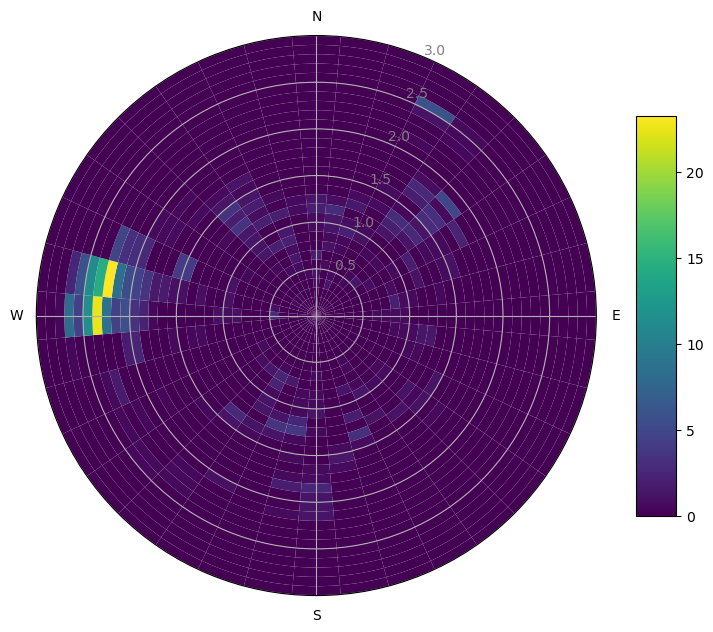

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import Normalize

import obspy
from obspy.core.util import AttribDict
from obspy.imaging.cm import obspy_sequential
from obspy.signal.invsim import corn_freq_2_paz
from obspy.signal.array_analysis import array_processing


# Load data
st = obspy.read("https://examples.obspy.org/agfa.mseed")

# Set PAZ and coordinates for all 5 channels
st[0].stats.paz = AttribDict({
    'poles': [(-0.03736 - 0.03617j), (-0.03736 + 0.03617j)],
    'zeros': [0j, 0j],
    'sensitivity': 205479446.68601453,
    'gain': 1.0})
st[0].stats.coordinates = AttribDict({
    'latitude': 48.108589,
    'elevation': 0.450000,
    'longitude': 11.582967})

st[1].stats.paz = AttribDict({
    'poles': [(-0.03736 - 0.03617j), (-0.03736 + 0.03617j)],
    'zeros': [0j, 0j],
    'sensitivity': 205479446.68601453,
    'gain': 1.0})
st[1].stats.coordinates = AttribDict({
    'latitude': 48.108192,
    'elevation': 0.450000,
    'longitude': 11.583120})

st[2].stats.paz = AttribDict({
    'poles': [(-0.03736 - 0.03617j), (-0.03736 + 0.03617j)],
    'zeros': [0j, 0j],
    'sensitivity': 250000000.0,
    'gain': 1.0})
st[2].stats.coordinates = AttribDict({
    'latitude': 48.108692,
    'elevation': 0.450000,
    'longitude': 11.583414})

st[3].stats.paz = AttribDict({
    'poles': [(-4.39823 + 4.48709j), (-4.39823 - 4.48709j)],
    'zeros': [0j, 0j],
    'sensitivity': 222222228.10910088,
    'gain': 1.0})
st[3].stats.coordinates = AttribDict({
    'latitude': 48.108456,
    'elevation': 0.450000,
    'longitude': 11.583049})

st[4].stats.paz = AttribDict({
    'poles': [(-4.39823 + 4.48709j), (-4.39823 - 4.48709j), (-2.105 + 0j)],
    'zeros': [0j, 0j, 0j],
    'sensitivity': 222222228.10910088,
    'gain': 1.0})
st[4].stats.coordinates = AttribDict({
    'latitude': 48.108730,
    'elevation': 0.450000,
    'longitude': 11.583157})


# Instrument correction to 1Hz corner frequency
paz1hz = corn_freq_2_paz(1.0, damp=0.707)
st.simulate(paz_remove='self', paz_simulate=paz1hz)

# Execute array_processing
kwargs = dict(
    # slowness grid: X min, X max, Y min, Y max, Slow Step
    sll_x=-3.0, slm_x=3.0, sll_y=-3.0, slm_y=3.0, sl_s=0.03,
    # sliding window properties
    win_len=1.0, win_frac=0.05,
    # frequency properties
    frqlow=1.0, frqhigh=8.0, prewhiten=0,
    # restrict output
    semb_thres=-1e9, vel_thres=-1e9,
    stime=obspy.UTCDateTime("20080217110515"),
    etime=obspy.UTCDateTime("20080217110545")
)
out = array_processing(st, **kwargs)

# Plot

cmap = obspy_sequential

# make output human readable, adjust backazimuth to values between 0 and 360
t, rel_power, abs_power, baz, slow = out.T
baz[baz < 0.0] += 360

# choose number of fractions in plot (desirably 360 degree/N is an integer!)
N = 36
N2 = 30
abins = np.arange(N + 1) * 360. / N
sbins = np.linspace(0, 3, N2 + 1)

# sum rel power in bins given by abins and sbins
hist, baz_edges, sl_edges = \
    np.histogram2d(baz, slow, bins=[abins, sbins], weights=rel_power)

# transform to radian
baz_edges = np.radians(baz_edges)

# add polar and colorbar axes
fig = plt.figure(figsize=(8, 8))
cax = fig.add_axes([0.85, 0.2, 0.05, 0.5])
ax = fig.add_axes([0.10, 0.1, 0.70, 0.7], polar=True)
ax.set_theta_direction(-1)
ax.set_theta_zero_location("N")

dh = abs(sl_edges[1] - sl_edges[0])
dw = abs(baz_edges[1] - baz_edges[0])

# circle through backazimuth
for i, row in enumerate(hist):
    bars = ax.bar((i * dw) * np.ones(N2),
                  height=dh * np.ones(N2),
                  width=dw, bottom=dh * np.arange(N2),
                  color=cmap(row / hist.max()))

ax.set_xticks(np.linspace(0, 2 * np.pi, 4, endpoint=False))
ax.set_xticklabels(['N', 'E', 'S', 'W'])

# set slowness limits
ax.set_ylim(0, 3)
[i.set_color('grey') for i in ax.get_yticklabels()]
ColorbarBase(cax, cmap=cmap,
             norm=Normalize(vmin=hist.min(), vmax=hist.max()))

plt.show()

## Seismogram Envelopes

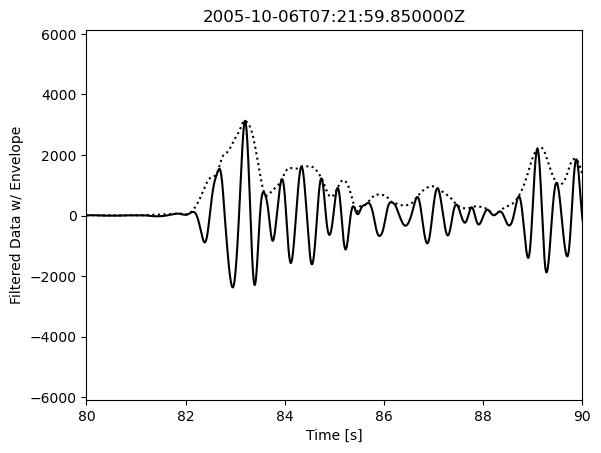

In [8]:
import numpy as np
import matplotlib.pyplot as plt

import obspy
import obspy.signal


st = obspy.read("https://examples.obspy.org/RJOB_061005_072159.ehz.new")
data = st[0].data
npts = st[0].stats.npts
samprate = st[0].stats.sampling_rate

# Filtering the Stream object
st_filt = st.copy()
st_filt.filter('bandpass', freqmin=1, freqmax=3, corners=2, zerophase=True)

# Envelope of filtered data
data_envelope = obspy.signal.filter.envelope(st_filt[0].data)

# The plotting, plain matplotlib
t = np.arange(0, npts / samprate, 1 / samprate)
plt.plot(t, st_filt[0].data, 'k')
plt.plot(t, data_envelope, 'k:')
plt.title(st[0].stats.starttime)
plt.ylabel('Filtered Data w/ Envelope')
plt.xlabel('Time [s]')
plt.xlim(80, 90)
plt.show()

## Plotting Spectrograms

In [ ]:
import obspy

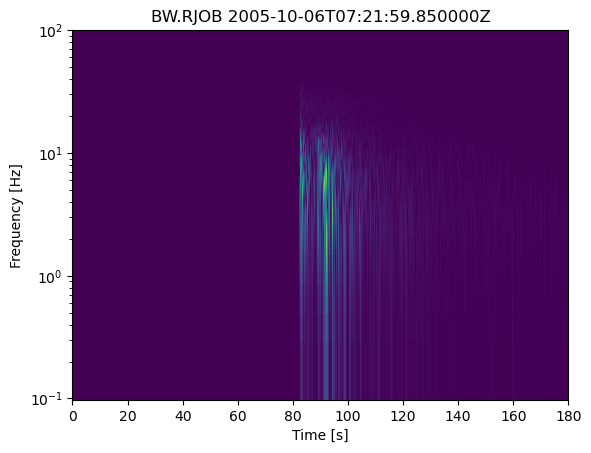

[None]

In [ ]:
st = obspy.read("https://examples.obspy.org/RJOB_061005_072159.ehz.new")
st.spectrogram(log=True, title='BW.RJOB ' + str(st[0].stats.starttime))